# RecSys Tutorial for the EvalRS 2023 hackaton 

## RecList sample evaluation notebook from saved predictions

In this notebook we provide an example on how you can take a parquet file with predictions/recommendations from a model and use [RecList](https://github.com/RecList/reclist) for evaluation.  
In this case, the prediction files are output from the models trained on [Merlin tutorial notebook](evalrs_kdd_2023_tutorial_retrieval_models_with_merlin_tf.ipynb).

## Setup

Installing the dependencies for this hackaton, including RecList

In [ ]:
!pip install -r ../../requirements.txt

In [3]:
import os
import sys
import pandas as pd
import numpy as np
import shutil
from functools import partial
sys.path.append(os.path.abspath('../../evaluation'))

from EvalRSRunner import ChallengeDataset
from EvalRSReclist import EvalRSReclist
from reclist.reclist import LOGGER, METADATA_STORE

## Predictions and events download

For your convenience, we have already run the [Merlin tutorial notebook](evalrs_kdd_2023_tutorial_retrieval_models_with_merlin_tf.ipynb) notebook in a V100 GPU and saved the [model prediction parquet files](https://drive.google.com/file/d/19Ea1UkosnpIbWdWG4_L7yLj-53egtNrP/view?usp=sharing).  
Download that file and uncompress inside the folder where this notebook is located, so that you have a `evalrs23_model_predictions` subfolder.


In [1]:
DATA_PATH = 'evalrs23_model_predictions/'

That folder contains the train/test events dataframe with the users we sampled when we trained the models and generated the predictions.

```
├── events_test.parquet
├── events_train.parquet
└── model_predictions
    ├── mf_test_preds.parquet
    └── tt_test_preds.parquet

```

In [4]:
events_train_df = pd.read_parquet(os.path.join(DATA_PATH, 'events_train.parquet'))
len(events_train_df)

6869679

In [5]:
events_test_df = pd.read_parquet(os.path.join(DATA_PATH, 'events_test.parquet'))
len(events_test_df)

29722

We made available prediction files for the following retrieval models:
- `mf_test_preds.parquet` - Matrix Factorization (uses only user id and item id)
- `tt_test_preds.parquet` - Two-Tower architecture (uses many user and item features)

In [6]:
preds_df = pd.read_parquet(os.path.join(DATA_PATH,'model_predictions/mf_test_preds.parquet'))
preds_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
user_id,,,,,,,,,,,,,,,,,,,,,
50967444,843773,1146746,1345792,17820138,282393,282394,161977,1157622,124951,1430102,...,184300,159791,125401,157787,159786,155899,15307,172299,20676,201808
50900118,22360044,1999651,531974,17816388,695679,5956595,19725189,19727955,29448037,970909,...,23564084,748983,23588321,1199647,612092,369223,1088505,70729,694797,337515
50086315,211514,217259,290742,1341673,216789,214869,215875,215736,217676,15513915,...,1115376,211647,211751,211553,211693,939254,215567,216227,215413,1341534
50085736,102662,102667,102663,102659,102658,116850,118966,102640,102642,28528,...,30172773,108764,108574,183004,19726572,11166942,136519,108573,116889,415119
50083088,98299,246468,1339576,95468,11112742,143531,246467,143535,511661,1374550,...,91843,453191,149695,94918,98676,92216,92663,754566,514485,92219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15067,12654387,12654384,12654388,12654386,12654389,7894841,13468147,12654383,12654385,7101844,...,877326,245076,2766073,1128417,11263846,1128059,22155617,1046910,877318,8690779
14308,20186,56917,20144,56916,20188,20189,247838,20147,20145,818751,...,131227,15469,1138896,9319564,161877,670540,4260,4129,504053,818808
12619,24418842,17145264,17145262,17145263,17145266,17145267,5478591,17145268,16592156,12890610,...,22071897,25488407,245084,6204095,16520995,22071896,24554520,19108087,4923350,25488410


## Dataset download and split

Let's download and uncompress the LastFM dataset and auxiliary tables we made available.  

In [8]:
# note, if YES, the dataset will be downloaded again
dataset = ChallengeDataset(force_download=False, 
                           folded_dataset_split = False,
                           sample_users_perc=0.25,
                           min_user_item_freq=10)  

evalrs_dataset_KDD_2023.zip: 100%|█████████| 1.60G/1.60G [01:59<00:00, 14.3MB/s]


Loading dataset.
Generating dataset hashes.


Here we set the train and test set to match the users we sampled when we generated the prediction files.  
The test set is defined as the last interaction for each user. So all users and items in test set are present in test set, as we are not focused in exploring the user/item cold-start problem in this example of music streaming domain.  

In [7]:
dataset._train_set = events_train_df
dataset._test_set = events_test_df

## Evaluating the prediction file

In [9]:
# Importing a similarity model from GenSim for the RecList "Being Less Wrong" metric
from gensim.models import KeyedVectors
similarity_model = KeyedVectors.load(os.path.join(dataset.path_to_dataset, 'song2vec.wv'))

Here are the `RecList` metrics for these predictions on LastFM users last' listened track

/usr/local/lib/python3.8/dist-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

stats:{'num_users': 29722, 'max_items': 1, 'min_items': 1}

HIT_RATE:0.048415315254693496

MRR:0.0022901478266583826

MRED_COUNTRY:{'mred': -0.008300676473591426, 'mr': 0.9505530006461176, 'BR': 0.9394871794871795, 'CA': 
0.9703703703703703, 'DE': 0.9561324977618622, 'ES': 0.9207317073170732, 'FI': 0.9569620253164557, 'FR': 
0.946969696969697, 'NL': 0.9591280653950953, 'NaN': 0.949115321872255, 'PL': 0.9506398537477148, 'RU': 
0.9526813880126183, 'SE': 0.9547038327526133, 'UA': 0.94, 'UK': 0.9555160142348754, 'US': 0.9585913312693498}

/usr/local/lib/python3.8/dist-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/usr/local/lib/python3.8/dist-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

MRED_USER_ACTIVITY:{'mred': -0.018456655729888676, 'mr': 0.9515846847453066, 1: 0.9050661798265632, 100: 
0.9549700085689803, 1000: 0.9570508231925555}

/usr/local/lib/python3.8/dist-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/usr/local/lib/python3.8/dist-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

MRED_TRACK_POPULARITY:{'mred': -0.01845813801658494, 'mr': 0.9515846847453066, 1: 1.0, 10: 0.9542479699430372, 100:
0.9449300699300699, 1000: 0.9676840215439856}

/usr/local/lib/python3.8/dist-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/usr/local/lib/python3.8/dist-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

MRED_ARTIST_POPULARITY:{'mred': -0.004770822480517467, 'mr': 0.9515846847453066, 1: 0.9511581067472307, 100: 
0.952972217910911, 1000: 0.9585687382297552, 10000: 0.9412995594713657}

/usr/local/lib/python3.8/dist-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

MRED_GENDER:{'mred': -0.00270451773156181, 'mr': 0.9515846847453066, 'f': 0.953877866529245, 'm': 
0.9548225887056472, 'n': 0.9490022172949002}

BEING_LESS_WRONG:0.3236536979675293

                                EvalRSReclist                                 
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                   Type ┃ Description  ┃                             Result ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                  stats │              │                                  { │
│                        │              │                "num_users": 29722, │
│                        │              │                    "max_items": 1, │
│                        │              │                     "min_items": 1 │
│                        │              │                                  } │
│               HIT_RATE │              │                             0.0484 │
│                    MRR │              │                             0.0023 │
│           MRED_COUNTRY │              │                                  { │
│                        │              │     "mred": -0.008300676473591426, │
│                        │              │          "mr": 0.9505530006461176, │
│                        │              │          "BR": 0.9394871794871795, │
│                        │              │          "CA": 0.9703703703703703, │
│                        │              │          "DE": 0.9561324977618622, │
│                        │              │          "ES": 0.9207317073170732, │
│                        │              │          "FI": 0.9569620253164557, │
│                        │              │           "FR": 0.946969696969697, │
│                        │              │          "NL": 0.9591280653950953, │
│                        │              │          "NaN": 0.949115321872255, │
│                        │              │          "PL": 0.9506398537477148, │
│                        │              │          "RU": 0.9526813880126183, │
│                        │              │          "SE": 0.9547038327526133, │
│                        │              │                        "UA": 0.94, │
│                        │              │          "UK": 0.9555160142348754, │
│                        │              │           "US": 0.9585913312693498 │
│                        │              │                                  } │
│     MRED_USER_ACTIVITY │              │                                  { │
│                        │              │     "mred": -0.018456655729888676, │
│                        │              │          "mr": 0.9515846847453066, │
│                        │              │           "1": 0.9050661798265632, │
│                        │              │         "100": 0.9549700085689803, │
│                        │              │         "1000": 0.9570508231925555 │
│                        │              │                                  } │
│  MRED_TRACK_POPULARITY │              │                                  { │
│                        │              │      "mred": -0.01845813801658494, │
│                        │              │          "mr": 0.9515846847453066, │
│                        │              │                          "1": 1.0, │
│                        │              │          "10": 0.9542479699430372, │
│                        │              │         "100": 0.9449300699300699, │
│                        │              │         "1000": 0.9676840215439856 │
│                        │              │                                  } │
│ MRED_ARTIST_POPULARITY │              │                                  { │
│                        │              │     "mred": -0.004770822480517467, │
│                        │              │          "mr": 0.9515846847453066, │
│                        │              │           "1": 0.9511581067472307, │
│                        │              │          "100": 0.952972217910911, │
│                        │              │        "1000": 0.9585687382297552, │
│                        │              │        "

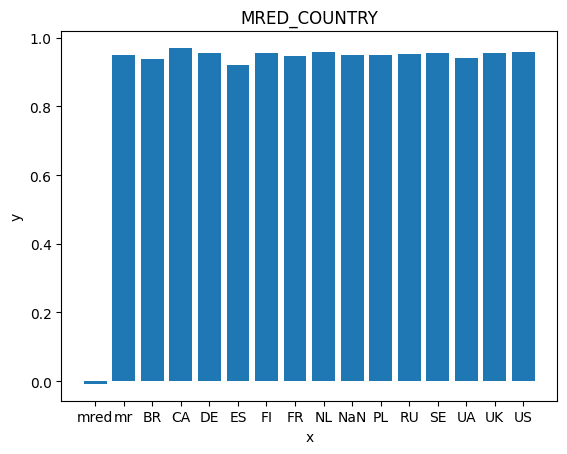

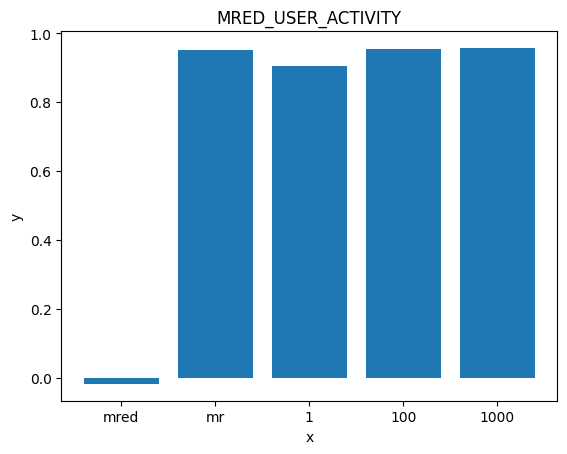

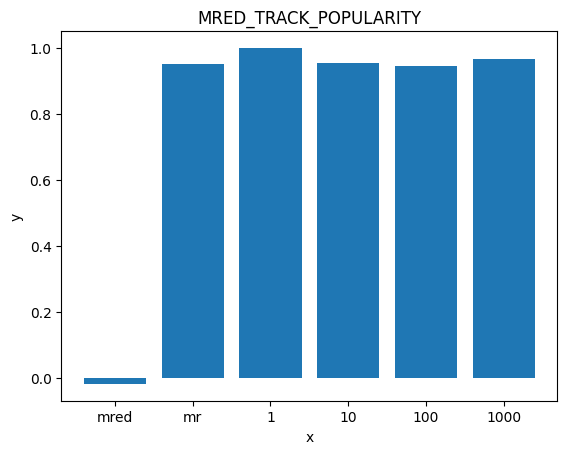

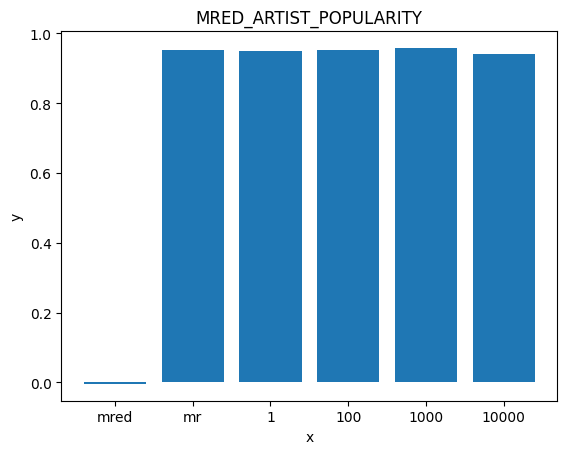

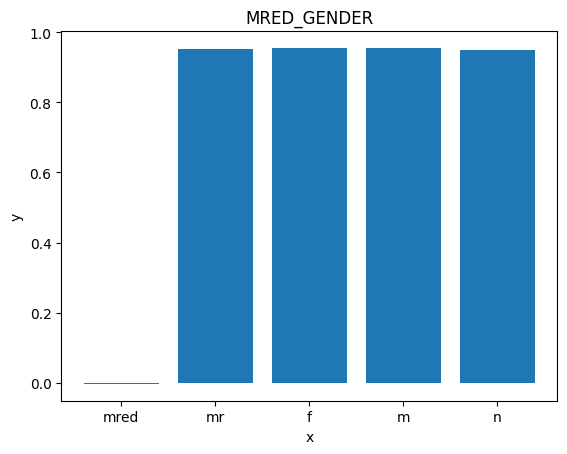

In [10]:
# initialize with everything
cdf = EvalRSReclist(
    dataset=dataset,
    model_name="PreTrainedModel",
    predictions=preds_df,
    logger=LOGGER.LOCAL,
    metadata_store=METADATA_STORE.LOCAL,
    similarity_model=similarity_model
)

# run reclist
cdf(verbose=True)